<a href="https://colab.research.google.com/github/miggelucas/NLP-studies/blob/main/NLP_Project_Udemy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___

<a href='http://www.pieriandata.com'> <img src='https://github.com/miggelucas/NLP-studies/blob/Pierian_Data_Logo.png?raw=1' /></a>
___

# Natural Language Processing Project

In this NLP project I tried to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. 

For this task I will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013). Althought, this dataset it's too big, so I decided to make a sample of it

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# The Data

Reading yelp_training_set_review.json and getting a sample 

In [ ]:
data = pd.read_json('/content/yelp_training_set_review.json', lines= True)

In [ ]:
# date, type, user_id, review_id and business_id don't seens to be useful, so I might drop this values
data.head()

,votes,user_id,review_id,stars,date,text,type,business_id
0,"{'funny': 0, 'useful': 5, 'cool': 2}",rLtl8ZkDX5vH5nAx9C3q5Q,fWKvX83p0-ka4JS3dc6E5A,5,2011-01-26,My wife took me here on my birthday for breakf...,review,9yKzy9PApeiPPOUJEtnvkg
1,"{'funny': 0, 'useful': 0, 'cool': 0}",0a2KyEL0d3Yb1V6aivbIuQ,IjZ33sJrzXqU-0X6U8NwyA,5,2011-07-27,I have no idea why some people give bad review...,review,ZRJwVLyzEJq1VAihDhYiow
2,"{'funny': 0, 'useful': 1, 'cool': 0}",0hT2KtfLiobPvh6cDC8JQg,IESLBzqUCLdSzSqm0eCSxQ,4,2012-06-14,love the gyro plate. Rice is so good and I als...,review,6oRAC4uyJCsJl1X0WZpVSA
3,"{'funny': 0, 'useful': 2, 'cool': 1}",uZetl9T0NcROGOyFfughhg,G-WvGaISbqqaMHlNnByodA,5,2010-05-27,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,_1QQZuf4zZOyFCvXc0o6Vg
4,"{'funny': 0, 'useful': 0, 'cool': 0}",vYmM4KTsC8ZfQBg-j5MWkw,1uJFq2r5QfJG_6ExMRCaGw,5,2012-01-05,General Manager Scott Petello is a good egg!!!...,review,6ozycU1RpktNG2-1BroVtw


In [ ]:
"""
a = time.time()
for vote in ['funny', 'useful', 'cool']:
  data[vote] = [x[1][0][vote] for x in data.iterrows()]

data.drop(columns= 'votes', inplace= True)
b = time.time()
print("essa operação levou: ", b-a)
"""

'\na = time.time()\nfor vote in [\'funny\', \'useful\', \'cool\']:\n  data[vote] = [x[1][0][vote] for x in data.iterrows()]\n\ndata.drop(columns= \'votes\', inplace= True)\nb = time.time()\nprint("essa operação levou: ", b-a)\n'

In [ ]:
# votes was kinds inside; putting values in columns
# alternative way that ended up been faster

for vote in  ['funny', 'useful', 'cool']:
  data[vote] = [data['votes'][x][vote] for x in range(len(data))]

data.drop(columns= ['votes', 'review_id', 'business_id', 'user_id', 'date', 'type'], inplace= True)
data.head()

,stars,text,funny,useful,cool
0,5,My wife took me here on my birthday for breakf...,0,5,2
1,5,I have no idea why some people give bad review...,0,0,0
2,4,love the gyro plate. Rice is so good and I als...,0,1,0
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",0,2,1
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0


In [ ]:
# data has 0 non-zero values
# data it's huge, might be worth to get a sample
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229907 entries, 0 to 229906
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   stars   229907 non-null  int64 
 1   text    229907 non-null  object
 2   funny   229907 non-null  int64 
 3   useful  229907 non-null  int64 
 4   cool    229907 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 8.8+ MB


In [ ]:
data.stars.value_counts()

4    79878
5    76193
3    35363
2    20957
1    17516
Name: stars, dtype: int64

In [ ]:
# geting 10000 for each stars category 
star1 = data[data['stars'] == 1].sample(17000)
star2 = data[data['stars'] == 2].sample(17000)
star3 = data[data['stars'] == 3].sample(17000)
star4 = data[data['stars'] == 4].sample(17000)
star5 = data[data['stars'] == 5].sample(17000)

df = pd.concat([star1, star2, star3, star4, star5])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85000 entries, 115101 to 186350
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   stars   85000 non-null  int64 
 1   text    85000 non-null  object
 2   funny   85000 non-null  int64 
 3   useful  85000 non-null  int64 
 4   cool    85000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.9+ MB


In [ ]:
df.reset_index(inplace= True)
df.drop(columns= 'index', inplace = True)
df.to_csv('yelp_short_17000.csv')

In [ ]:
df.to_csv('yelp_short_17000.csv')

# The dataframe

In [4]:
df = pd.read_csv('yelp_short_17000.csv')
df.drop(columns= ['Unnamed: 0'], inplace= True)
df.dropna(inplace= True)
df.head()

,stars,text,funny,useful,cool
0,1,I had great costumer service with the girl beh...,0,0,0
1,1,The food was never great here. But now it's go...,1,0,0
2,1,The bartender stole my debit card and then sai...,0,0,0
3,1,I just had the ice cream. That was when I didn...,1,1,1
4,1,Not good. OCB is not a place for quality dinin...,1,0,0


In [ ]:
df.describe()

,stars,funny,useful,cool
count,84999.000000,84999.000000,84999.000000,84999.000000
mean,2.999976,0.773209,1.440311,0.801621
std,1.414214,1.966750,2.215631,1.827585
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,1.000000,0.000000
75%,4.000000,1.000000,2.000000,1.000000
max,5.000000,70.000000,120.000000,117.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84999 entries, 0 to 84999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   stars   84999 non-null  int64 
 1   text    84999 non-null  object
 2   funny   84999 non-null  int64 
 3   useful  84999 non-null  int64 
 4   cool    84999 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.9+ MB


In [ ]:
df['lenght'] = [len(x) for x in df['text'].astype(str)]
df

,stars,text,funny,useful,cool,lenght
0,1,Beware of the minute clinic. Paid copay and b...,1,1,1,414
1,1,Why does this place get business? There are on...,0,0,0,439
2,1,I called North Valley to make an appointment. ...,0,1,0,1537
3,1,"Back when I lived in Phoenix, I used to come t...",0,1,0,529
4,1,I have never stayed at Diamond Resorts Interna...,0,2,0,607
...,...,...,...,...,...,...
84995,5,This is the best local sushi spot I've ever be...,0,0,0,434
84996,5,My wife and I found this place last night. We ...,0,1,0,354
84997,5,My wife and I bought our wedding rings here. ...,0,4,0,321
84998,5,The Arizona Renaissance Festival has been an a...,0,1,1,4061


# EDA


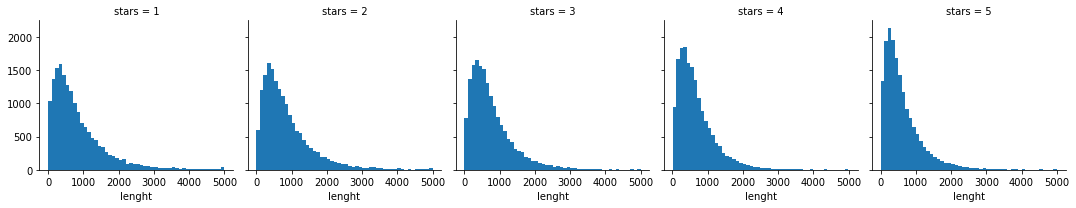

In [ ]:
g = sns.FacetGrid(df,col='stars')
g.map(plt.hist,'lenght', bins= 50)

**Create a boxplot of text length for each star category.**

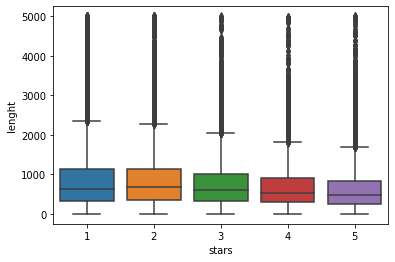

In [ ]:
sns.boxplot(data= df, x= 'stars', y= 'lenght')

In [ ]:
df.groupby('stars').mean()

,funny,useful,cool,lenght
stars,,,,
1,0.931353,1.562529,0.544941,847.210588
2,0.893412,1.552941,0.729176,863.944824
3,0.766235,1.370765,0.858765,771.058765
4,0.678176,1.379471,0.970824,678.615882
5,0.596859,1.335843,0.904406,625.836873


In [ ]:
df.groupby('stars').mean().corr()

,funny,useful,cool,lenght
funny,1.000000,0.940027,-0.882173,0.982984
useful,0.940027,1.000000,-0.882548,0.900344
cool,-0.882173,-0.882548,1.000000,-0.812211
lenght,0.982984,0.900344,-0.812211,1.000000


**Then use seaborn to create a heatmap based off that .corr() dataframe:**

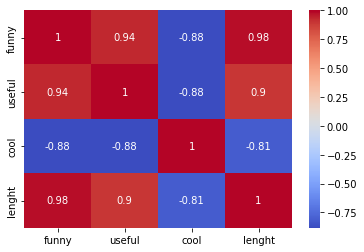

In [ ]:
sns.heatmap(df.groupby('stars').mean().corr(), cmap='coolwarm',annot=True)

# NLP Classification Task level 1

In [5]:
# To make things easier, working only with 1 and 5 stars
# For this level 1, I'll be using only vectors and NB
data_class = df[(df.stars == 1) | (df.stars == 5)]
data_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33999 entries, 0 to 84999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   stars   33999 non-null  int64 
 1   text    33999 non-null  object
 2   funny   33999 non-null  int64 
 3   useful  33999 non-null  int64 
 4   cool    33999 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.6+ MB


In [6]:
data_class.stars.unique()

array([1, 5])

In [19]:
X = data_class['text']
y = data_class['stars']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state = 101)

In [20]:
cv = CountVectorizer()
X_train = cv.fit_transform(X_train_raw)
X_test = cv.transform(X_test_raw)

In [21]:
modelo = MultinomialNB().fit(X_train, y_train)

In [22]:
predictions = modelo.predict(X_test)

In [23]:
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[3879  350]
 [ 338 3933]]


              precision    recall  f1-score   support

           1       0.92      0.92      0.92      4229
           5       0.92      0.92      0.92      4271

    accuracy                           0.92      8500
   macro avg       0.92      0.92      0.92      8500
weighted avg       0.92      0.92      0.92      8500



In [28]:
testing = ['I really liked', 'I hated', "I don't liked", "I don't get the point. why does it have to be so bad?"]
vec_testing = cv.transform(testing)
print(f"modelo vetorial: {modelo.predict_proba(vec_testing)}")

modelo vetorial: [[0.3166824  0.6833176 ]
 [0.85991071 0.14008929]
 [0.44041131 0.55958869]
 [0.97087593 0.02912407]]


## Using pipeline
Can I get same results using a pipeline?

In [12]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('classifier', MultinomialNB()),  # train on vectors w/ Naive Bayes classifier
])

In [13]:
X = data_class['text']
y = data_class['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 101)

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

In [14]:
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[3879  350]
 [ 338 3933]]


              precision    recall  f1-score   support

           1       0.92      0.92      0.92      4229
           5       0.92      0.92      0.92      4271

    accuracy                           0.92      8500
   macro avg       0.92      0.92      0.92      8500
weighted avg       0.92      0.92      0.92      8500



In [30]:
testing = ['I really liked', 'I hated', "I don't liked", "I don't get the point. why does it have to be so bad?"]
print(f'Pipeline_vec {pipeline.predict_proba(testing)}')

Pipeline_vec [[0.3166824  0.6833176 ]
 [0.85991071 0.14008929]
 [0.44041131 0.55958869]
 [0.97087593 0.02912407]]


# Using Text Processing Level 2


In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [ ]:
X = data_class['text']
y = data_class['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 101)

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predictions = pipeline.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[4034  195]
 [ 478 3793]]


              precision    recall  f1-score   support

           1       0.89      0.95      0.92      4229
           5       0.95      0.89      0.92      4271

    accuracy                           0.92      8500
   macro avg       0.92      0.92      0.92      8500
weighted avg       0.92      0.92      0.92      8500



In [ ]:
# Trying RandomForestClassifier

pipeline_forest = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ RandomForestClassifier()
])

X = data_class['text']
y = data_class['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 101)

pipeline_forest.fit(X_train, y_train)

predictions = pipeline_forest.predict(X_test)

print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[3920  309]
 [ 464 3807]]


              precision    recall  f1-score   support

           1       0.89      0.93      0.91      4229
           5       0.92      0.89      0.91      4271

    accuracy                           0.91      8500
   macro avg       0.91      0.91      0.91      8500
weighted avg       0.91      0.91      0.91      8500



# Using Text Processing Level 3
removing stopwords and ponctuations

In [ ]:
# downloading stopwords
# nltk.download_shell()

In [ ]:
from nltk.corpus import stopwords
import string 

def text_process(mess):
  # 1. remove punctuation
  # 2. remove stop words
  # 3. return list of clean text words

  nopunc = [char for char in mess if char not in string.punctuation]
  
  nopunc = ''.join(nopunc)

  return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [ ]:
pipeline_naive = Pipeline([
                     ('bow', CountVectorizer(analyzer = text_process)),
                     ('tidf', TfidfTransformer()),
                     ('classifier', MultinomialNB())
])

X = data_class['text']
y = data_class['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 101)

pipeline_naive.fit(X_train, y_train)

predictions = pipeline_naive.predict(X_test)

print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[4035  194]
 [ 470 3801]]


              precision    recall  f1-score   support

           1       0.90      0.95      0.92      4229
           5       0.95      0.89      0.92      4271

    accuracy                           0.92      8500
   macro avg       0.92      0.92      0.92      8500
weighted avg       0.92      0.92      0.92      8500



In [ ]:
testing = ['I really liked', 'I hated', "I don't liked", "I don't get the point. why does it have to be so bad?"]
print(pipeline.predict(testing))
print(pipeline_naive.predict(testing))
print(pipeline_naive.predict_proba(testing))

[5 1 5 1]
[5 1 5 1]
[[0.38533575 0.61466425]
 [0.78342911 0.21657089]
 [0.46991305 0.53008695]
 [0.80020864 0.19979136]]


In [ ]:

pipeline_forest = Pipeline([
    ('bow', CountVectorizer(analyzer = text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ RandomForestClassifier()
])

X = data_class['text']
y = data_class['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 101)

pipeline_forest.fit(X_train, y_train)

predictions = pipeline_forest.predict(X_test)

print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[3941  288]
 [ 475 3796]]


              precision    recall  f1-score   support

           1       0.89      0.93      0.91      4229
           5       0.93      0.89      0.91      4271

    accuracy                           0.91      8500
   macro avg       0.91      0.91      0.91      8500
weighted avg       0.91      0.91      0.91      8500

